<a href="https://colab.research.google.com/github/ElMartinez31/Data_Science/blob/main/Dataloaders_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder # Stream data from images stored in folders
from tqdm import tqdm

import os # Allows to access files
import numpy as np
from PIL import Image # Allows us to Load Images
from collections import Counter # Utility function to give us the counts of unique items in an iterable


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_dog_folder = "/content/drive/Othercomputers/Mon ordinateur portable/Data Science/cats_and_dogs_filtered/train/dogs"
path_cat_folder = "/content/drive/Othercomputers/Mon ordinateur portable/Data Science/cats_and_dogs_filtered/train/cats"


path_dog_files = os.listdir(path_dog_folder)
path_cat_files = os.listdir(path_cat_folder)

dog_files = [os.path.join(path_dog_folder, dog_file) for dog_file in path_dog_files]
cat_files = [os.path.join(path_cat_folder,cat_file) for cat_file in path_cat_files]

len(cat_files + dog_files) # 2000

#training = cat_files + dog_files

#training[0]

2000

In [ ]:
# let's create our class custrom dataset

class CustomDataset(Dataset):
  def __init__(self, path_to_folder):#/content/drive/Othercomputers/Mon ordinateur portable/Data Science/cats_and_dogs_filtered/train
    path_dog_folder = os.path.join(path_to_folder, "dogs")
    path_cat_folder = os.path.join(path_to_folder, "cats")

    path_dog_files = os.listdir(path_dog_folder)
    path_cat_files = os.listdir(path_cat_folder)

    dog_files = [os.path.join(path_dog_folder, dog_file) for dog_file in path_dog_files]
    cat_files = [os.path.join(path_cat_folder, cat_file) for cat_file in path_cat_files]


    self.dog_label, self.cat_label = 0,1

    self.training_files = dog_files + cat_files # concat both lists
    self.transform = transforms.Compose([
         transforms.Resize((224,224)),# as img are not all the same size (so they can't stack in dataloader),
         transforms.ToTensor()# convert to tensors
        ])



  def __len__(self):
    return len(self.training_files)

  def __getitem__(self, idx):
    path_img = self.training_files[idx]
    if "cat." in path_img:
      label = self.cat_label # cat
    else:
      label = self.dog_label # dog

    image = Image.open(path_img).convert("RGB")
    #display(image)
    image = self.transform(image)

    return image, label



In [ ]:
path = "/content/drive/Othercomputers/Mon ordinateur portable/Data Science/cats_and_dogs_filtered/train"

catsndogs = CustomDataset(path)
# for img, label in catsndogs:
#   display(img)
#   print("label", label)
#   print(img.shape)


# loader = DataLoader(catsndogs, batch_size = 16, shuffle = True)
# for img, label in loader:
#   print(img,label)
#   break


In [ ]:
### Create a Composition of Transformations
# we will use it as parameter in our __init__()
img_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)), # Resize the image from whatever it is to a [3, 224, 224] image
        transforms.RandomHorizontalFlip(p=0.5), # Do a random flip with 50% probability
        transforms.ToTensor(), # Convert the image to a Tensor
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]) # Normalize the Image
    ]
)

### Lets Add this to our Dataset Class
class DogsVsCats(Dataset):
    def __init__(self, path_to_folder, transforms): ### Our INIT Now Accepts a Transforms

        ### PREVIOUS CODE ###
        path_to_cats = os.path.join(path_to_folder, "cats")
        path_to_dogs = os.path.join(path_to_folder, "dogs")
        dog_files = os.listdir(path_to_dogs)
        cat_files = os.listdir(path_to_cats)
        path_to_dog_files = [os.path.join(path_to_dogs, file) for file in dog_files]
        path_to_cat_files = [os.path.join(path_to_cats, file) for file in cat_files]
        self.training_files = path_to_dog_files + path_to_cat_files
        self.dog_label, self.cat_label = 0, 1


        ### NEW CODE ###
        # self.transform = transforms.ToTensor() -> Notice how our transforms was just ToTensor before. It will be our Composition of Transforms now!
        self.transform = transforms

    def __len__(self):
        return len(self.training_files) # The number of samples we have is just the number of training files we have

    def __getitem__(self, idx):
        ### PREVIOUS CODE ###
        path_to_image = self.training_files[idx] # Grab file path at the sampled index
        if "dog." in path_to_image: # If the word "Dog" is in the filepath, then set the label to 0
            label = self.dog_label
        else:
            label = self.cat_label # Otherwise set the label to 1
        image = Image.open(path_to_image) # Open Image with PIL to create a PIL Image

        ### UPDATED CODE ###
        image = self.transform(image) # Image now will go through series of transforms indicated in self.transform
        return image, label


### Instantiate Dataset With the Transforms ###
dogvcat = DogsVsCats(path_to_folder=path,
                     transforms=img_transforms)


dogsvcatsloader = DataLoader(dogvcat,
                             batch_size=16,
                             shuffle=True)

for images, labels in dogsvcatsloader:
    print(images.shape)
    print(labels)
    break


torch.Size([16, 3, 224, 224])
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0])


In [ ]:
# so now we have our class well defined, and a dataloader ready.
# But if we want to train a CNN, we need to randomly split the data


train_samples = int(0.9 * len(dogvcat)) # 90%train
test_samples = len(dogvcat) - train_samples # 10% test

print("Number of Training Samples:", train_samples, "Number of Test Samples", test_samples)

train_dataset, test_dataset = torch.utils.data.random_split(dogvcat, lengths=[train_samples, test_samples]) # Split with the dataset by the lenghts

train_loader = DataLoader(train_dataset, shuffle = True, batch_size = 16 )
test_loader = DataLoader(test_dataset, shuffle = True, batch_size = 16)


Number of Training Samples: 1800 Number of Test Samples 200


In [ ]:
for img, lbl in train_loader:
  print(img, lbl)
  break
  #ok

tensor([[[[-0.9705, -0.9363, -0.8849,  ..., -1.2103, -1.1760, -1.2445],
          [-0.9534, -0.9363, -0.9363,  ..., -1.1760, -1.1589, -1.1932],
          [-0.8849, -0.8849, -0.9534,  ..., -1.0219, -1.0904, -1.1418],
          ...,
          [-1.0048, -0.9534, -1.0219,  ..., -1.3815, -1.4500, -1.4500],
          [-1.0390, -0.9705, -1.0390,  ..., -1.3473, -1.4329, -1.4329],
          [-1.0219, -0.9877, -1.0390,  ..., -1.3302, -1.3987, -1.3987]],

         [[-0.8102, -0.7752, -0.7227,  ..., -1.0903, -1.0028, -1.0553],
          [-0.7927, -0.7752, -0.7752,  ..., -1.0903, -1.0203, -1.0028],
          [-0.7227, -0.7227, -0.7927,  ..., -0.9853, -0.9853, -1.0028],
          ...,
          [-0.4776, -0.4076, -0.4776,  ..., -0.9853, -1.0553, -1.0553],
          [-0.4776, -0.4076, -0.4776,  ..., -0.9503, -1.0378, -1.0378],
          [-0.4601, -0.4251, -0.4776,  ..., -0.9328, -1.0028, -1.0028]],

         [[-0.4973, -0.4624, -0.4101,  ..., -0.5147, -0.4973, -0.6018],
          [-0.4798, -0.4624, -

In [ ]:
# Now that we have both our train and test loader, we need to prepare the CNN for the trainig.
import torch
import torch.nn as nn
import torch.nn.functional as F

# Img size (16,3,224,224) #batch, Channels, h,H
class Dogs_n_Cats_Recognizer(nn.Module):
  def __init__(self):
    super(Dogs_n_Cats_Recognizer, self).__init__()

    # Entrée : (16, 3, 224, 224)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # -> (16, 16, 224, 224)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                                # -> (16, 16, 112, 112)

    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) # -> (16, 32, 112, 112)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                                # -> (16, 32, 56, 56)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # -> (16, 64, 56, 56)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)                                # -> (16, 64, 28, 28)

    # Flatten
    self.flatten_size = 64 * 28 * 28  # = 50176

    self.fc1 = nn.Linear(in_features=self.flatten_size, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)
    x = x.view(-1, self.flatten_size)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

model = Dogs_n_Cats_Recognizer()

In [ ]:
# 2nd version with dropout and batchnorm

import torch
import torch.nn as nn
import torch.nn.functional as F

class Dogs_n_Cats_Recognizer(nn.Module):
    def __init__(self):
        super(Dogs_n_Cats_Recognizer, self).__init__()

        # Conv + Pool + BatchNorm
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten_size = 64 * 28 * 28  # = 50176

        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.dropout = nn.Dropout(p=0.5)  # Dropout 50%
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout during training
        x = self.fc2(x)
        return x

model = Dogs_n_Cats_Recognizer()


In [ ]:
# Train
from torch.optim import Adam
from tqdm import tqdm

#optim
optim = Adam(params=model.parameters(), lr=0.001)
# Fonction de perte
criter = nn.CrossEntropyLoss()# 2 neurons as output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


model.train()
epochs = 100
acc_list = []
loss_list = []
for epoch in tqdm(range(epochs)):
  loss_counter = 0
  total = 0
  correct_preds = 0
  for inputs, labels in (train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    optim.zero_grad()
    #forward
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    # print("\n outputs",outputs)
    # print("\n preds",predicted)
    # print("\n labels",labels)
    loss = criter(outputs, labels)
    loss.backward()
    optim.step()
    correct_preds += (predicted == labels).sum().item()
    total += labels.size(0)
    # print("total: ", total)
    # print("correct_preds", correct_preds)
    loss_counter += loss.item() # reinitialisé à chaque epoch
    # print("epoch: ", epoch)
    # print("loss_counter: ", loss_counter)
    accuracy = correct_preds/total
    # print("acc: ", accuracy)

  print("epoch : ", epoch)
  acc_list.append(accuracy)
  loss_list.append(loss_counter)
  print(f"accuracy for epoch {epoch}", accuracy)
  print(f"loss for epoch {epoch}", loss_counter)














  0%|          | 0/100 [01:58<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
  correct_preds = 0
  total = 0
  for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    total += labels.size(0)
    correct_preds += (preds == labels).sum().item()
  accuracy_test = correct_preds / total
  print("accuracy on test set = ", accuracy_test)



In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(range(epochs),  acc_list, label ="Accuracy", color = 'orange' )
plt.title("train accuracy with epoch")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.subplot(2,1,2)
plt.plot(range(epochs), loss_list, label = "Loss", color = 'blue')
plt.title("train loss with epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
# score and display a random image

#load image
# apply same transformation
# send to model
# display and score
# avec Rwenach

In [ ]:
from imageio import imread
rwenn_path = "/content/IMG_20240713_123511.jpg"
chien2_path = "/content/IMG_20240601_132643.jpg"
chien3_path = "/content/IMG_20240601_131146.jpg"
chat_path = "/content/American_shorthair_7c6e670822.jpg"
list_chien = []
list_chien.append(rwenn_path)
list_chien.append(chien2_path)
list_chien.append(chien3_path)
list_chien.append(chat_path)

for img in list_chien:

  # Application des mêmes transforms que pour le dataset

  #Affichage de l'image
  raw_img = Image.open(img).convert("RGB")
  input_tensor = img_transforms(raw_img).unsqueeze(0).to(device)

  output = model(input_tensor)
  pred = torch.argmax(output,dim = 1).item()
  print(pred)
  plt.imshow(raw_img)
  label_map = {0: "Chien", 1: "Chat"}
  plt.title(f"Prediction : {label_map[pred]}" )
  plt.axis("off")
  plt.show()

In [ ]:
########### Using pretrained model ################"


from torchvision import models
import torch.nn as nn

# 1. Charger ResNet18 pré-entraîné
resnet = models.resnet18(pretrained=True)

# Get fc.in_features layer
num_features = resnet.fc.in_features
num_features

# Changer le FC layer pour l'avoir en sortie à 2 classes.
resnet.fc = nn.Linear(in_features = num_features, out_features = 2)

# freezer other layers (optional)
for param in resnet.parameters():
  param.requires_grad = False
for param in resnet.fc.parameters():
  param.requires_grad = True

# Acceleration
resnet = resnet.to(device)

# optim & criterion
criter = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params = resnet.fc.parameters(), lr = 0.001)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


In [ ]:
# So now we juste need to train (fine tune) this model


# train on one epoch
resnet.train()
epochs = 25

accuracies = []
losses = []
for epoch in tqdm(range(epochs)):
  loss_cumul = 0
  total = 0
  correct_preds = 0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = resnet(inputs)
    # print("out", outputs)
    # print("labels", labels)
    loss = criter(outputs, labels)
    optim.zero_grad()
    loss.backward()
    optim.step()
    _, preds = torch.max(outputs, 1)
    # print("preds", preds)
    loss_cumul += loss
    total += labels.size(0)
    correct_preds += (preds == labels).sum()
    accuracy = correct_preds / total

  accuracies.append(accuracy)
  losses.append(loss_cumul)
  print(f"epoch: {epoch}, accuracy: {accuracy}, loss: {loss}")


  4%|▍         | 1/25 [00:24<09:36, 24.02s/it]

epoch: 0, accuracy: 0.9433333277702332, loss: 0.0402340292930603


  8%|▊         | 2/25 [00:35<06:23, 16.65s/it]

epoch: 1, accuracy: 0.9522222280502319, loss: 0.031021665781736374


 12%|█▏        | 3/25 [00:47<05:14, 14.30s/it]

epoch: 2, accuracy: 0.9450000524520874, loss: 0.281677782535553


 16%|█▌        | 4/25 [00:58<04:37, 13.23s/it]

epoch: 3, accuracy: 0.9611111283302307, loss: 0.3127705454826355


 20%|██        | 5/25 [01:10<04:16, 12.85s/it]

epoch: 4, accuracy: 0.9605555534362793, loss: 0.008611111901700497


 24%|██▍       | 6/25 [01:24<04:10, 13.18s/it]

epoch: 5, accuracy: 0.9600000381469727, loss: 0.005753234028816223


 28%|██▊       | 7/25 [01:35<03:45, 12.54s/it]

epoch: 6, accuracy: 0.9477778077125549, loss: 0.02503553032875061


 32%|███▏      | 8/25 [01:46<03:25, 12.06s/it]

epoch: 7, accuracy: 0.9577777981758118, loss: 1.0430017709732056


 36%|███▌      | 9/25 [01:58<03:10, 11.90s/it]

epoch: 8, accuracy: 0.9650000333786011, loss: 0.014583085663616657


 40%|████      | 10/25 [02:10<02:58, 11.92s/it]

epoch: 9, accuracy: 0.9688889384269714, loss: 0.44844070076942444


 44%|████▍     | 11/25 [02:21<02:44, 11.77s/it]

epoch: 10, accuracy: 0.9661111235618591, loss: 0.13279864192008972


 48%|████▊     | 12/25 [02:33<02:31, 11.69s/it]

epoch: 11, accuracy: 0.9661111235618591, loss: 0.03063209168612957


 52%|█████▏    | 13/25 [02:44<02:19, 11.58s/it]

epoch: 12, accuracy: 0.9738889336585999, loss: 0.17429250478744507


 56%|█████▌    | 14/25 [02:56<02:06, 11.51s/it]

epoch: 13, accuracy: 0.9711111187934875, loss: 0.0022131004370748997


 60%|██████    | 15/25 [03:06<01:53, 11.34s/it]

epoch: 14, accuracy: 0.9622222185134888, loss: 0.27574625611305237


 64%|██████▍   | 16/25 [03:18<01:41, 11.28s/it]

epoch: 15, accuracy: 0.9655556082725525, loss: 0.19775086641311646


 68%|██████▊   | 17/25 [03:29<01:30, 11.36s/it]

epoch: 16, accuracy: 0.9688889384269714, loss: 0.0488969087600708


 72%|███████▏  | 18/25 [03:41<01:19, 11.42s/it]

epoch: 17, accuracy: 0.9588888883590698, loss: 0.2669091820716858


 76%|███████▌  | 19/25 [03:52<01:08, 11.44s/it]

epoch: 18, accuracy: 0.9688889384269714, loss: 0.10248096287250519


 80%|████████  | 20/25 [04:04<00:57, 11.44s/it]

epoch: 19, accuracy: 0.9638888835906982, loss: 0.41973456740379333


 84%|████████▍ | 21/25 [04:15<00:45, 11.43s/it]

epoch: 20, accuracy: 0.96833336353302, loss: 0.0645575150847435


 88%|████████▊ | 22/25 [04:26<00:34, 11.36s/it]

epoch: 21, accuracy: 0.9733333587646484, loss: 0.010805584490299225


 92%|█████████▏| 23/25 [04:37<00:22, 11.28s/it]

epoch: 22, accuracy: 0.96833336353302, loss: 0.6313891410827637


 96%|█████████▌| 24/25 [04:49<00:11, 11.40s/it]

epoch: 23, accuracy: 0.9694444537162781, loss: 0.003718423657119274


100%|██████████| 25/25 [05:01<00:00, 12.06s/it]

epoch: 24, accuracy: 0.9688889384269714, loss: 0.17783451080322266


16
16
16
16
16
16
16
16
16
16
16
16
8
test accuracy: 0.99, test loss: 0.5488372328691185
preds tensor([0], device='cuda:0')


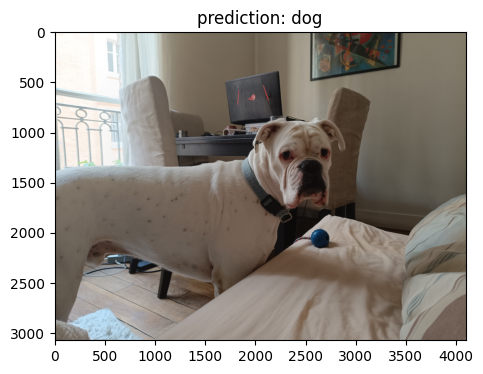

preds tensor([0], device='cuda:0')


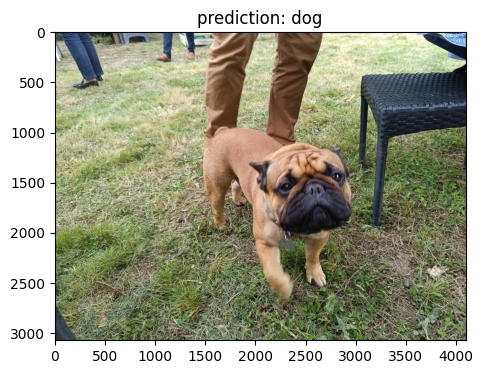

preds tensor([0], device='cuda:0')


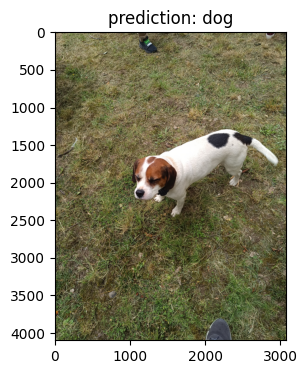

preds tensor([1], device='cuda:0')


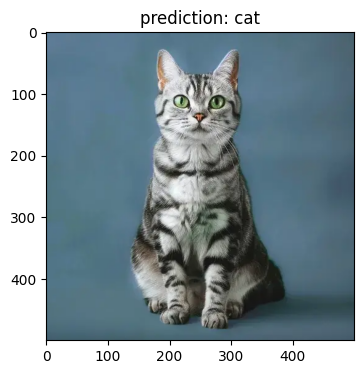

In [ ]:
import matplotlib.pyplot as plt
resnet.eval()
with torch.no_grad():
  total = 0
  correct_preds = 0
  loss_cumul = 0
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    print(labels.size(0))
    # print(inputs.shape)# [B, Channels, H, W]
    outputs = resnet(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criter(outputs, labels)
    loss_cumul += loss.item()
    total += labels.size(0)
    correct_preds += (preds == labels).sum().item()
acc = correct_preds / total

print(f'test accuracy: {acc}, test loss: {loss_cumul}')

# now let's predict on my own data

dog_list = [
"/content/IMG_20240713_123511.jpg",
 "/content/IMG_20240601_132643.jpg",
"/content/IMG_20240601_131146.jpg",
"/content/American_shorthair_7c6e670822.jpg"
]



for path in dog_list:
  raw_img = Image.open(path).convert("RGB")
  raw_img = raw_img
  tensor_img = img_transforms(raw_img).unsqueeze(0).to(device)
  #print(tensor_img.shape)# [Channels, H, W] need to unsqueeze to get batch dim
  output = resnet(tensor_img)
  label_map = {0 : "dog", 1 : "cat"}
  _, pred = torch.max(output, 1)
  print("preds", pred)
  pred = label_map[pred.item()]
  plt.figure(figsize= (6,4))
  plt.imshow(raw_img)
  plt.title(f'prediction: {pred}')
  plt.show()


